In [3]:
from circuits import IQPLikeCircuit, Separable_rx, HardwareEfficientEmbeddingCircuit, HEEAndChebyshevTower
from squlearn.kernel import ProjectedQuantumKernel, FidelityKernel
from qiskit.primitives import Estimator, Sampler
from squlearn.util import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit

import numpy as np

In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import I, Z, X
from qiskit.quantum_info import Pauli, SparsePauliOp, random_statevector
from qiskit.circuit import ParameterVector
#import Pauli and PauliOp


Hamiltonian Evolution Feature Map

In [156]:
#This feature map represents a d-dimensional datapoint as a d+1-qubit quantum state

def Hamiltonian_time_evolution_encoding(n_components, trotter_time_T, evolve_time_t):
    """#This feature map represents a n_components-dimensional datapoint as a n_components+1-qubit quantum state

    Power of data paper uses 

    trotter_time_T = 20 # Trotter time is equivalent to layers of the circuit
    evolve_time_t = n_components/3
    """
    n_qubits = n_components + 1 
    features = ParameterVector('x', n_components)

    def H_j(j, n_qubits):
        I_tensor = Pauli("I" * n_qubits)
        X_j = I_tensor.copy()
        X_j[j] = Pauli("X")
        X_jp1 = I_tensor.copy()
        X_jp1[j + 1] = Pauli("X")

        Y_j = I_tensor.copy()
        Y_j[j] = Pauli("Y")
        Y_jp1 = I_tensor.copy()
        Y_jp1[j + 1] = Pauli("Y")

        Z_j = I_tensor.copy()
        Z_j[j] = Pauli("Z")
        Z_jp1 = I_tensor.copy()
        Z_jp1[j + 1] = Pauli("Z")
        return SparsePauliOp(X_j@X_jp1) + SparsePauliOp(Y_j@Y_jp1) + SparsePauliOp(Z_j@Z_jp1)

    evolve_block = [PauliEvolutionGate(H_j(j, n_qubits), time=features[j]*evolve_time_t/trotter_time_T) for j in range(n_components)]
    
    circuit = QuantumCircuit(n_qubits)


    initial_state = [1/np.sqrt(2), -1/np.sqrt(2)]
    random_haar_states = [random_statevector(2, seed = seed) for seed in range(n_qubits)]
    for i in range(n_qubits):
        circuit.initialize(random_haar_states[i], i)

    for _ in range(trotter_time_T):
        for evo in evolve_block:
            circuit.append(evo, range(n_qubits))
    return circuit


In [181]:
num_qubits = 3

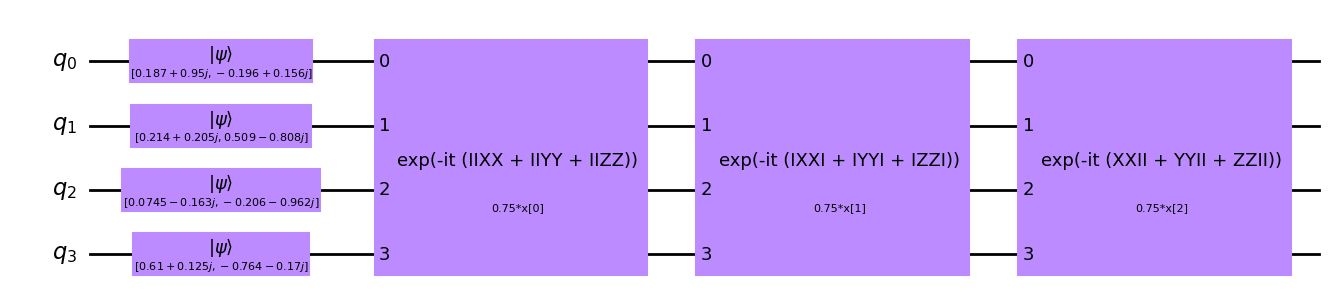

In [185]:
circuit = Hamiltonian_time_evolution_encoding(num_qubits,1, 0.75)
circuit.draw("mpl")


In [ ]:
HEEAndChebyshevTower

In [182]:
fmap = QiskitEncodingCircuit(circuit)


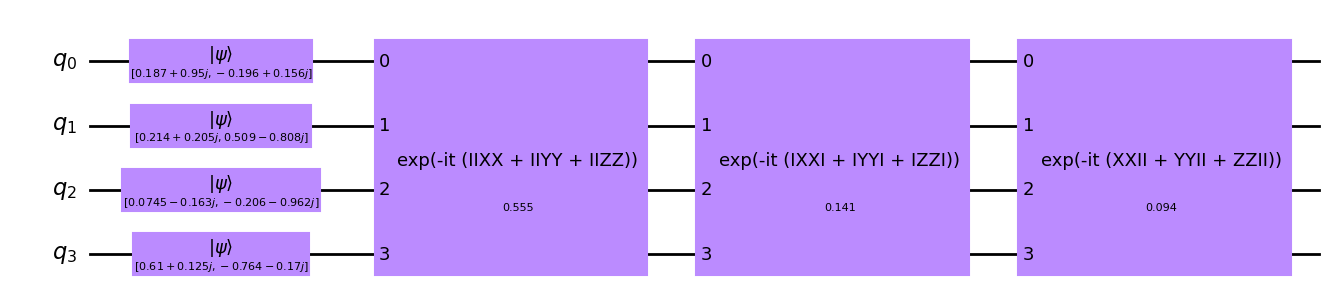

In [183]:
fmap.get_circuit(x[0], 0).draw("mpl")

In [184]:
x = np.random.rand(10,num_qubits)

executor_projected_exact = Executor(Estimator())
executor_projected_exact.set_shots(None)
PQK_exact = ProjectedQuantumKernel(fmap, executor=executor_projected_exact, outer_kernel="gaussian", gamma=0.5)
PQK_exact.evaluate(x)

array([[1.        , 0.76092693, 0.62166108, 0.46597232, 0.14794503,
        0.44951664, 0.46846903, 0.06481153, 0.31297163, 0.24333786],
       [0.76092693, 1.        , 0.63462647, 0.45332649, 0.24986465,
        0.8186598 , 0.85364154, 0.18064975, 0.48409353, 0.29682679],
       [0.62166108, 0.63462647, 1.        , 0.18598784, 0.08368747,
        0.36519579, 0.41561663, 0.0498474 , 0.15053397, 0.10699593],
       [0.46597232, 0.45332649, 0.18598784, 1.        , 0.09299839,
        0.28238148, 0.33222992, 0.04359111, 0.80365502, 0.14383552],
       [0.14794503, 0.24986465, 0.08368747, 0.09299839, 1.        ,
        0.44423922, 0.19053149, 0.71434739, 0.16502965, 0.89360325],
       [0.44951664, 0.8186598 , 0.36519579, 0.28238148, 0.44423922,
        1.        , 0.81113221, 0.4475463 , 0.43253316, 0.42119631],
       [0.46846903, 0.85364154, 0.41561663, 0.33222992, 0.19053149,
        0.81113221, 1.        , 0.18685959, 0.45649376, 0.19690267],
       [0.06481153, 0.18064975, 0.0498474

In [40]:
circuit == circuit_

False

IQP Like

C:\Users\jsl-rf\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


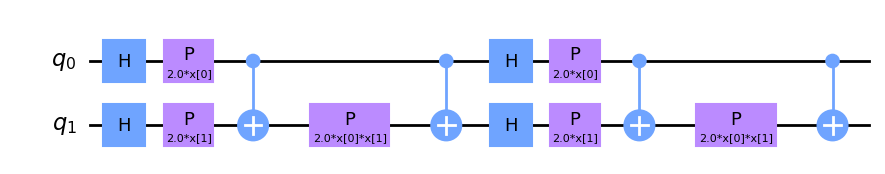

In [2]:
num_qubits = 2
num_layers = 2
x = np.random.rand(10,num_qubits)
fmap = IQPLikeCircuit(num_qubits = num_qubits, num_layers=num_layers)
fmap.draw(output='mpl')

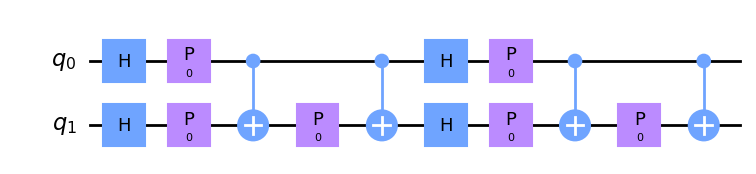

In [3]:
fmap.get_circuit(np.zeros(num_qubits), None).draw(output='mpl')

In [4]:
x = np.random.rand(10,num_qubits)

executor_projected_exact = Executor(Estimator())
executor_projected_exact.set_shots(None)
PQK_exact = ProjectedQuantumKernel(fmap, executor=executor_projected_exact, outer_kernel="gaussian", gamma=0.5)
PQK_exact.evaluate(x)

array([[1.        , 0.39778872, 0.8959903 , 0.94209542, 0.48549337,
        0.99741783, 0.60217294, 0.50162437, 0.66082191, 0.48538826],
       [0.39778872, 1.        , 0.30208236, 0.3225633 , 0.42955475,
        0.38089954, 0.77949351, 0.87079741, 0.19967219, 0.68356355],
       [0.8959903 , 0.30208236, 1.        , 0.92290345, 0.39774302,
        0.90487898, 0.39933175, 0.3948765 , 0.70590077, 0.3976229 ],
       [0.94209542, 0.3225633 , 0.92290345, 1.        , 0.33750363,
        0.9625574 , 0.505931  , 0.37446314, 0.56711517, 0.34490676],
       [0.48549337, 0.42955475, 0.39774302, 0.33750363, 1.        ,
        0.4509643 , 0.46628005, 0.70799985, 0.6544489 , 0.88481481],
       [0.99741783, 0.38089954, 0.90487898, 0.9625574 , 0.4509643 ,
        1.        , 0.58694479, 0.4721162 , 0.64198812, 0.4517116 ],
       [0.60217294, 0.77949351, 0.39933175, 0.505931  , 0.46628005,
        0.58694479, 1.        , 0.74331163, 0.27327565, 0.60114137],
       [0.50162437, 0.87079741, 0.3948765

Separable U

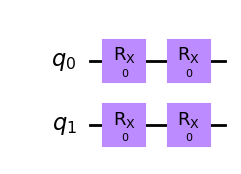

In [5]:
fmap = Separable_rx(num_qubits, num_layers)
fmap.get_circuit(np.zeros(num_qubits), None).draw(output='mpl')

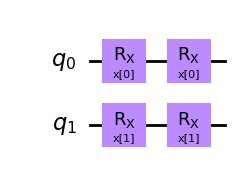

In [6]:
fmap = Separable_rx(num_qubits, num_layers)
fmap.draw(output='mpl')

In [7]:
HEEAndChebyshevTower?

Signature: HEEAndChebyshevTower(num_qubits, num_features, num_layers)
Docstring: <no docstring>
File:      c:\users\jsl-rf\desktop\kernelsde\circuits\circuits.py
Type:      function

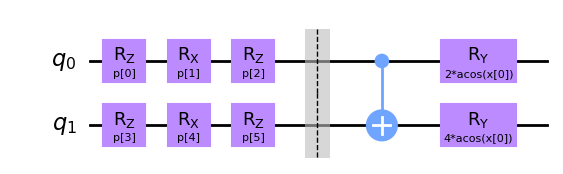

In [11]:
fmap = HEEAndChebyshevTower(2, 1, 1)
fmap.draw(output='mpl')

In [7]:
executor_projected_exact = Executor(Estimator())
executor_projected_exact.set_shots(None)
PQK_exact = ProjectedQuantumKernel(fmap, executor=executor_projected_exact, outer_kernel="gaussian", gamma=0.5)
PQK_exact.evaluate(x)

array([[1.        , 0.45195126, 0.94143223, 0.96243132, 0.62433488,
        0.99851715, 0.35798791, 0.71543621, 0.76426812, 0.68750535],
       [0.45195126, 1.        , 0.31378407, 0.38106586, 0.46526943,
        0.44068529, 0.89973023, 0.77086078, 0.25883524, 0.63563357],
       [0.94143223, 0.31378407, 1.        , 0.96767209, 0.5057227 ,
        0.95058435, 0.24328245, 0.54215411, 0.76557293, 0.53493104],
       [0.96243132, 0.38106586, 0.96767209, 1.        , 0.47408933,
        0.97545864, 0.32251286, 0.57350357, 0.6686948 , 0.53370592],
       [0.62433488, 0.46526943, 0.5057227 , 0.47408933, 1.        ,
        0.59355689, 0.30292632, 0.84361512, 0.78449236, 0.94911765],
       [0.99851715, 0.44068529, 0.95058435, 0.97545864, 0.59355689,
        1.        , 0.35414094, 0.68947379, 0.74591743, 0.65749406],
       [0.35798791, 0.89973023, 0.24328245, 0.32251286, 0.30292632,
        0.35414094, 1.        , 0.56417137, 0.17064664, 0.43349854],
       [0.71543621, 0.77086078, 0.5421541

HEE rx

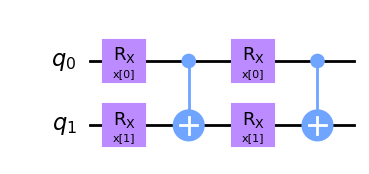

In [8]:
fmap = HardwareEfficientEmbeddingCircuit(num_qubits=num_qubits, num_layers=num_layers, rotation_gate="rx")
fmap.draw(output='mpl')

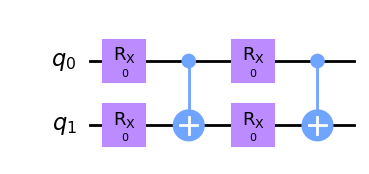

In [9]:
fmap.get_circuit(np.zeros(num_qubits), None).draw(output='mpl') 

In [22]:
executor_projected_exact = Executor(Estimator(), shots=None, primitive_seed=1)

PQK_exact = ProjectedQuantumKernel(fmap, executor=executor_projected_exact, outer_kernel="gaussian", gamma=0.5)
PQK_exact.evaluate(x)

array([[1.        , 0.61786313, 0.95685333, 0.97865572, 0.77968282,
        0.99920563, 0.63117407, 0.77893093, 0.926218  , 0.77514951],
       [0.61786313, 1.        , 0.48813155, 0.56419206, 0.73043731,
        0.60896986, 0.95924131, 0.8854101 , 0.47708022, 0.8230201 ],
       [0.95685333, 0.48813155, 1.        , 0.98670898, 0.63399875,
        0.96538552, 0.52208609, 0.62161413, 0.90644013, 0.61949819],
       [0.97865572, 0.56419206, 0.98670898, 1.        , 0.67035023,
        0.98597414, 0.6053622 , 0.68360003, 0.88368013, 0.67044177],
       [0.77968282, 0.73043731, 0.63399875, 0.67035023, 1.        ,
        0.75930317, 0.64408018, 0.9463623 , 0.79009763, 0.98215664],
       [0.99920563, 0.60896986, 0.96538552, 0.98597414, 0.75930317,
        1.        , 0.62812119, 0.76195159, 0.92018616, 0.75595468],
       [0.63117407, 0.95924131, 0.52208609, 0.6053622 , 0.64408018,
        0.62812119, 1.        , 0.80108874, 0.46808337, 0.7297461 ],
       [0.77893093, 0.8854101 , 0.6216141

In [32]:
executor_projected_exact = Executor(Estimator(), shots=500000, primitive_seed=1)

PQK_exact = ProjectedQuantumKernel(fmap, executor=executor_projected_exact, outer_kernel="gaussian", gamma=0.5)
PQK_exact.evaluate(x)

array([[1.        , 0.61809082, 0.9564256 , 0.97843653, 0.7803531 ,
        0.99904357, 0.62972759, 0.77888691, 0.92648276, 0.77536194],
       [0.61809082, 1.        , 0.48859775, 0.56410106, 0.73065319,
        0.60872068, 0.95903802, 0.88586231, 0.4777044 , 0.82344875],
       [0.9564256 , 0.48859775, 1.        , 0.98690614, 0.63371209,
        0.96588512, 0.52125194, 0.62109378, 0.90568198, 0.61900072],
       [0.97843653, 0.56410106, 0.98690614, 1.        , 0.67052447,
        0.98641754, 0.60371475, 0.68312993, 0.88385189, 0.67020433],
       [0.7803531 , 0.73065319, 0.63371209, 0.67052447, 1.        ,
        0.75829473, 0.64301558, 0.94619744, 0.79064162, 0.9821894 ],
       [0.99904357, 0.60872068, 0.96588512, 0.98641754, 0.75829473,
        1.        , 0.62661678, 0.76059072, 0.91992678, 0.75465216],
       [0.62972759, 0.95903802, 0.52125194, 0.60371475, 0.64301558,
        0.62661678, 1.        , 0.8003871 , 0.46720313, 0.72909748],
       [0.77888691, 0.88586231, 0.6210937

In [57]:
executor_fi = Executor(Sampler())
executor_fi.set_shots(5)
executor_fi.set_seed_for_primitive(1)

FQK_exact = FidelityKernel(fmap, executor=executor_fi)
FQK_exact.evaluate(x)

array([[1.        , 0.62767535, 0.97032478, 0.98426686, 0.83636906,
        0.99943029, 0.59926377, 0.83710405, 0.93125078, 0.83958781],
       [0.62767535, 1.        , 0.45800534, 0.52643979, 0.76927026,
        0.61083718, 0.97327798, 0.90994222, 0.52260053, 0.85727905],
       [0.97032478, 0.45800534, 1.        , 0.98999047, 0.72725804,
        0.97592652, 0.43925437, 0.69603887, 0.92333201, 0.70955056],
       [0.98426686, 0.52643979, 0.98999047, 1.        , 0.73876294,
        0.98961706, 0.51548172, 0.74002652, 0.89401541, 0.73990305],
       [0.83636906, 0.76927026, 0.72725804, 0.73876294, 1.        ,
        0.81890401, 0.66147408, 0.95389775, 0.87864402, 0.98539401],
       [0.99943029, 0.61083718, 0.97592652, 0.98961706, 0.81890401,
        1.        , 0.5863079 , 0.82079716, 0.92523621, 0.82230321],
       [0.59926377, 0.97327798, 0.43925437, 0.51548172, 0.66147408,
        0.5863079 , 1.        , 0.83561078, 0.46142944, 0.76350116],
       [0.83710405, 0.90994222, 0.6960388